In [1]:
import os
import random
import numpy as np
import gc
from pathlib import Path

import torch
import torch.nn.functional as F
import lightning as L

from scipy.ndimage import gaussian_gradient_magnitude, laplace

from minerva.data.datasets.supervised_dataset import SupervisedReconstructionDataset
from minerva.data.readers.png_reader import PNGReader
from minerva.data.readers.tiff_reader import TiffReader
from minerva.models.nets.image.segment_anything.sam_lora import SAMLoRA
from minerva.transforms.transform import _Transform
from minerva.pipelines.lightning_pipeline import SimpleLightningPipeline
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt

print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())
print("CUDA Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA Device")

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


PyTorch Version: 2.5.1+cu124
CUDA Version: 12.4
CUDA Available: True
CUDA Device Count: 1
CUDA Device Name: NVIDIA GeForce RTX 4090


In [2]:
# f3
train_path = "/workspaces/Minerva-Discovery/shared_data/seismic/f3_segmentation/images"
annotation_path = "/workspaces/Minerva-Discovery/shared_data/seismic/f3_segmentation/annotations"

# seam-ai (parihaka)
# train_path = "/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/images"
# annotation_path = "/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/annotations"

checkpoint_path = "/workspaces/Minerva-Discovery/shared_data/weights_sam/checkpoints_sam/sam_vit_b_01ec64.pth"

In [3]:
class PatchingTolstayaModule(L.LightningDataModule):
    def __init__(
        self,
        train_path: str,
        annotations_path: str,
        patch_size: int = 255,
        stride: int = 32,
        batch_size: int = 8,
        transforms: _Transform = None,
        num_workers: int = None,
    ):
        super().__init__()
        self.train_path = Path(train_path)
        self.annotations_path = Path(annotations_path)
        self.transforms = transforms
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.stride = stride
        self.num_workers = num_workers if num_workers else os.cpu_count()

        self.datasets = {}

    # função útil
    def normalize_data(self, data):
        """
        Normaliza os valores dos pixels para o intervalo [0, 1].
        """
        data_min, data_max = data.min(), data.max()
        return (data - data_min) / (data_max - data_min)
    
    # função útil
    def generate_depth_channel(self, shape):
        """
        Função responsável por criar o canal de profundidade, com 0 no topo e 1 na base.
        """
        depth_channel = np.linspace(0, 1, shape[0]).reshape(-1, 1)
        return np.tile(depth_channel, (1, shape[1]))
    
    # função útil
    def extract_patches(self, data, patch_size=255, stride=32, img_type='image'):
        patches = []
        if img_type == 'image': # caso seja imagens de entrada (h, w, c)
            h, w, _ = data.shape
        else: # caso seja labels de entrada (h, w)
            h, w = data.shape
        for i in range(0, h - patch_size + 1, stride):
            for j in range(0, w - patch_size + 1, stride):
                patch = data[i:i + patch_size, j:j + patch_size]
                if img_type == 'image':
                    patches.append(patch.transpose(2, 0, 1).astype(np.float32)) # o SAM só recebe (C H W)
                else:
                    patches.append(patch) #.astype(np.int64)
        return np.array(patches)
    
    # funcao utils
    def generate_facies_probability_channel(self, patch, facies_probabilities):
        prob_map = np.random.choice(
            len(facies_probabilities), size=patch.shape, p=facies_probabilities
            )
        return prob_map

    # funcao util
    def generate_amplitude_gradient_channel(self, patch):
        # Usa gradiente de amplitude com suavização
        gradient_channel = gaussian_gradient_magnitude(patch, sigma=1)
        return gradient_channel / np.max(gradient_channel)  # Normalização

    # funcao util
    def generate_curvature_channel(self, patch):
        # Calcula a curvatura usando o filtro de Laplace
        curvature_channel = laplace(patch)
        return curvature_channel / np.max(np.abs(curvature_channel))  # Normaliza para [-1, 1]

    # função útil
    def generate_image_with_depth(self, normalized_images):
        two_channel_images = []
        for img in normalized_images:  # Garantir que está trabalhando com imagens normalizadas
            depth_channel = self.generate_depth_channel(img.shape[:2])  # Gerar canal de profundidade para esta imagem

            if img.shape[-1] > 1:  # Se a imagem tiver múltiplos canais
                # Escolher apenas o primeiro canal (exemplo, pode ser qualquer canal)
                img = img[:, :, 0:1]  # Seleciona o primeiro canal e mantém as dimensões (H, W, 1)
            
            # gerando canal 3 (teste)
            # facies_probabilities = np.array([0.2857, 0.1207, 0.4696, 0.0747, 0.0361, 0.0132])
            # canal_3 = self.generate_facies_probability_channel(img, facies_probabilities)
            canal_2 = self.generate_amplitude_gradient_channel(img)
            canal_3 = self.generate_curvature_channel(img)

            # Concatenar o primeiro canal com o depth_channel
            depth_channel = np.expand_dims(depth_channel, axis=-1)  # Tornar (H, W, 1)
            two_channel_image = np.concatenate((img, canal_2, canal_3), axis=-1)  # Concatenar ao longo do eixo dos canais
            two_channel_images.append(two_channel_image)  # Adicionar ao array final
        return two_channel_images
    
    # função util
    def horizontal_flip(self, image, label):
        if not isinstance(image, np.ndarray):
            raise ValueError(f"Experado image com type <class 'numpy.ndarray'>, mas foi recebido {type(image)}")
        if not isinstance(label, np.ndarray):
            raise ValueError(f"Experado label com type <class 'numpy.ndarray'>, mas foi recebido {type(label)}")

        if image.shape[0] != 3 or image.shape[1] != self.patch_size or image.shape[2] != self.patch_size:
            raise ValueError(f"Experado image com shape (C=3 H=patch_size W=patch_size), mas foi recebido {image.shape}")
        if label.shape[0] != self.patch_size or label.shape[1] != self.patch_size:
            raise ValueError(f"Experado label com shape (H=patch_size W=patch_size), mas foi recebido {label.shape}")

        image_flipped = np.flip(image, axis=2)
        label_flipped = np.flip(label, axis=1)

        # if any(s < 0 for s in image_flipped.strides):
        #     print(f"array com strides negativos detectado")

        return image_flipped.copy(), label_flipped.copy()
    
    def setup(self, stage=None):
        if stage == "fit":
            train_img_reader = [self.normalize_data(image) for image in TiffReader(self.train_path / "train")] # lendo imagens e normalizando
            train_label_reader = PNGReader(self.annotations_path / "train")
            
            # Gerar imagens com canais de profundidade
            # train_img_reader = self.generate_image_with_depth(train_img_reader)
            
            # Gerar patches em batches
            patches_img_generator = []
            for image in train_img_reader:
                patches_img_generator.extend(self.extract_patches(image, self.patch_size, self.stride))
            patches_label_generator = []
            for image in train_label_reader:
                patches_label_generator.extend(self.extract_patches(image, self.patch_size, self.stride, img_type='label'))

            # """ augmentation """
            # # Aplicar augmentações nas imagens e labels, somente para as amostras com 3, 4 ou 6 classes
            # augmented_img_generator = []
            # augmented_label_generator = []
            # for img, label in zip(patches_img_generator, patches_label_generator):
            #     # TODO tá estourando nessa parte
            #     augmented_img_generator.append(img)
            #     augmented_label_generator.append(label)
            #     # Verificar o número de classes na amostra
            #     unique_classes = np.unique(label)
            #     num_classes = len(unique_classes)
                
            #     if num_classes in [3, 4, 6]:  # Apenas aplicar augmentação nas amostras com 3, 4 ou 6 classes
            #         img_horizontal_flip, label_horizontal_flip = self.horizontal_flip(img, label)
            #         augmented_img_generator.append(img_horizontal_flip)
            #         augmented_label_generator.append(label_horizontal_flip)
            
            # Criar dataset para treinamento
            self.datasets["train"] = SupervisedReconstructionDataset(
                readers=[patches_img_generator, patches_label_generator],
                transforms=self.transforms,
            )
            del train_img_reader, train_label_reader
            del patches_img_generator, patches_label_generator
            # del augmented_img_generator, augmented_label_generator
            gc.collect()

            val_img_reader = [self.normalize_data(image) for image in TiffReader(self.train_path / "val")]
            val_label_reader = PNGReader(self.annotations_path / "val")

            # gerar imagens com canais de profundidade
            # val_img_reader = self.generate_image_with_depth(val_img_reader)

            # Gerar patches em batches
            patches_img_generator = []
            for image in val_img_reader:
                patches_img_generator.extend(self.extract_patches(image, self.patch_size, self.stride))
            patches_label_generator = []
            for image in val_label_reader:
                patches_label_generator.extend(self.extract_patches(image, self.patch_size, self.stride, img_type='label'))

            self.datasets["val"] = SupervisedReconstructionDataset(
                readers=[patches_img_generator, patches_label_generator],
                transforms=self.transforms,
            )
            del val_img_reader, val_label_reader
            del patches_img_generator, patches_label_generator
            gc.collect()
        
        elif stage == "test" or stage == "predict":
            test_img_reader = [self.normalize_data(image) for image in TiffReader(self.train_path / "test")]
            test_label_reader = PNGReader(self.annotations_path / "test")

            # gerar imagens com canais de profundidade
            # test_img_reader = self.generate_image_with_depth(test_img_reader)

            # Gerar patches em batches
            patches_img_generator = []
            for image in test_img_reader:
                patches_img_generator.extend(self.extract_patches(image, self.patch_size, self.stride))
            patches_label_generator = []
            for image in test_label_reader:
                patches_label_generator.extend(self.extract_patches(image, self.patch_size, self.stride, img_type='label'))

            test_dataset = SupervisedReconstructionDataset(
                readers=[patches_img_generator, patches_label_generator],
                transforms=self.transforms,
            )
            del test_img_reader, test_label_reader
            del patches_img_generator, patches_label_generator
            gc.collect()

            self.datasets["test"] = test_dataset
            self.datasets["predict"] = test_dataset

        else:
            raise ValueError(f"Invalid stage: {stage}")

    def train_dataloader(self):
        return DataLoader(
            self.datasets["train"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True, 
            drop_last=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.datasets["val"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True, 
            drop_last=False
        )

    def test_dataloader(self):
        return DataLoader(
            self.datasets["test"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True, 
            drop_last=False
        )

    def predict_dataloader(self):
        return DataLoader(
            self.datasets["predict"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True, 
            drop_last=False
        )

    def worker_init_fn(self, worker_id):
        random.seed(18 + worker_id)

In [4]:
# import torchvision.transforms as transforms
# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((64, 64)), 
#     transforms.ToTensor()
# ])

data_module = PatchingTolstayaModule(
    train_path=train_path,
    annotations_path=annotation_path,
    patch_size=64,
    stride=16,
    batch_size=100,
    # transforms=[transform, transform]
)

In [5]:
# data_module.setup(stage='fit')
# train_loader = data_module.train_dataloader()
# for batch in train_loader:
#     x, label = batch
#     print(x.shape, label.shape)  # Imprime o shape do tensor
# torch.Size([8, 64, 64, 3]) torch.Size([8, 64, 64])
#     break

In [6]:
from minerva.models.nets.image.convae import ConvVAE
model = ConvVAE(layers=[64, 64, 128, 256, 512], z_size=64)

In [7]:
from lightning.pytorch.callbacks import ModelCheckpoint
from datetime import datetime

current_date = datetime.now().strftime("%Y-%m-%d")

# Define o callback para salvar o modelo com base no menor valor da métrica de validação
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss", # Métrica para monitorar
    dirpath="./checkpoints", # Diretório onde os checkpoints serão salvos
    filename=f"convVAE-sam_model-{current_date}-{{epoch:02d}}-{{val_loss:.2f}}", # Nome do arquivo do checkpoint
    save_top_k=1, # Quantos melhores checkpoints salvar (no caso, o melhor)
    mode="min", # Como a métrica deve ser tratada (no caso, 'min' significa que menor valor de val_loss é melhor)
)

# from lightning.pytorch.loggers import TensorBoardLogger
# # Defina o logger do TensorBoard
# logger = TensorBoardLogger("logs", name="sam_model")

from lightning.pytorch.loggers import CSVLogger

logger = CSVLogger("logs", name="conv_vae")

trainer = L.Trainer(
    max_epochs=30,
    accelerator="gpu",
    devices=1,
    logger=logger,
    callbacks=[checkpoint_callback],
)
# trainer.fit(model, data_module)

pipeline = SimpleLightningPipeline(
    model=model,
    trainer=trainer,
    save_run_status=True
)

pipeline.run(data=data_module, task="fit")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Log directory set to: /workspaces/Minerva-Discovery/my_experiments/vae_v1/notebook/logs/conv_vae/version_0


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /workspaces/Minerva-Discovery/my_experiments/vae_v1/notebook/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | encoder   | Sequential | 724 K  | train
1 | fc_mu     | Linear     | 262 K  | train
2 | fc_logvar | Linear     | 262 K  | train
3 | fc_decode | Linear     | 266 K  | train
4 | decoder   | Sequential | 724 K  | train
-------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.957     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


Pipeline info saved at: /workspaces/Minerva-Discovery/my_experiments/vae_v1/notebook/logs/conv_vae/version_0/run_2024-11-23-01-50-134d29a089385c444aaa84e22d6ef53bc0.yaml


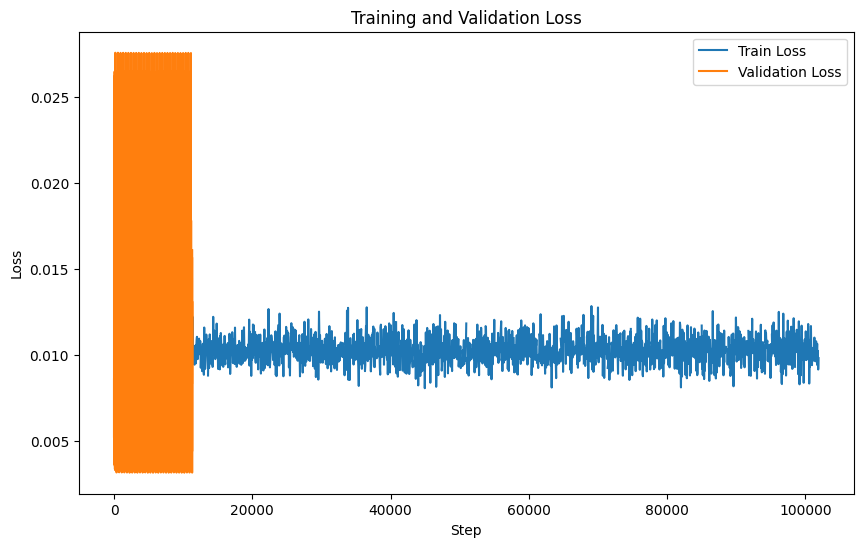

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Ler logs do CSV
logs = pd.read_csv("logs/conv_vae/version_0/metrics.csv")

# Gerar gráfico de loss
plt.figure(figsize=(10, 6))
plt.plot(logs["step"], logs["train_loss_step"], label="Train Loss")
plt.plot(logs["step"], logs["val_loss_step"], label="Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [9]:
logs

,epoch,step,train_logvar_mean_epoch,train_logvar_mean_step,train_logvar_std_epoch,train_logvar_std_step,train_loss_epoch,train_loss_step,train_mu_mean_epoch,train_mu_mean_step,train_mu_std_epoch,train_mu_std_step,val_logvar_mean,val_logvar_std,val_loss_epoch,val_loss_step,val_mu_mean,val_mu_std
0,0.0,49,NaN,-0.000021,NaN,0.000452,NaN,0.010972,NaN,4.217992e-06,NaN,0.000420,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,99,NaN,0.000007,NaN,0.000307,NaN,0.009629,NaN,-2.347638e-06,NaN,0.000308,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,149,NaN,-0.000003,NaN,0.000259,NaN,0.010284,NaN,9.129182e-06,NaN,0.000260,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,199,NaN,0.000006,NaN,0.000201,NaN,0.010068,NaN,-6.264041e-07,NaN,0.000207,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,249,NaN,0.000002,NaN,0.000173,NaN,0.009910,NaN,2.897962e-06,NaN,0.000169,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13403,NaN,11307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010235,NaN,NaN
13404,NaN,11308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008371,NaN,NaN
13405,NaN,11309,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016078,NaN,NaN
13406,29.0,101939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.258086e-07,0.000002,0.01025,NaN,-2.404922e-07,0.000002


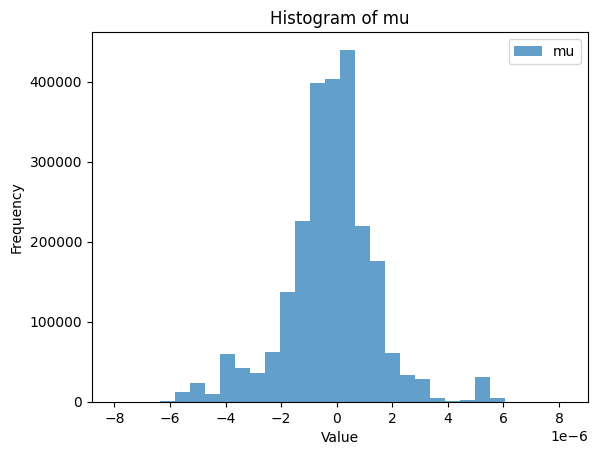

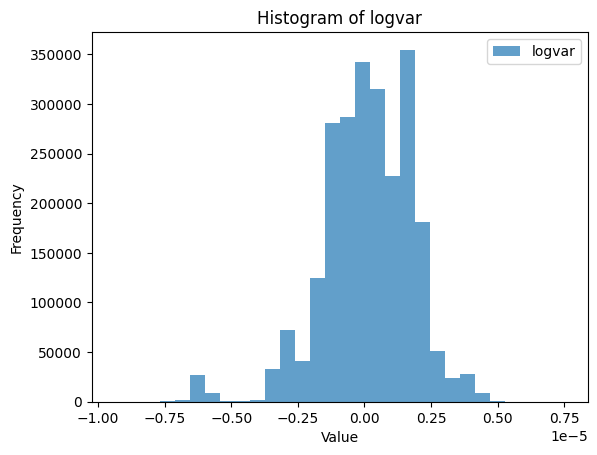

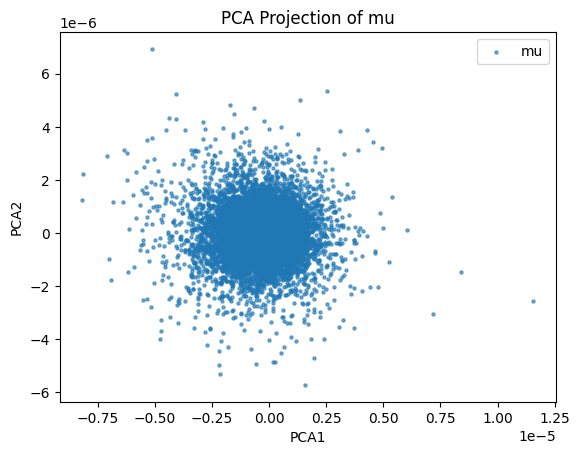

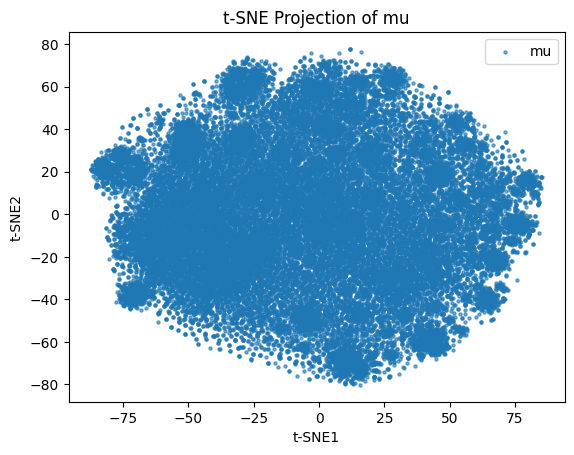

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Carregar os valores salvos
mu_values = np.load("mu_values.npy")
logvar_values = np.load("logvar_values.npy")

# 3.1. Histogramas de mu e logvar
plt.hist(mu_values.flatten(), bins=30, alpha=0.7, label="mu")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of mu")
plt.legend()
plt.show()

plt.hist(logvar_values.flatten(), bins=30, alpha=0.7, label="logvar")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of logvar")
plt.legend()
plt.show()

# 3.2. Projeção Multidimensional
# PCA
pca = PCA(n_components=2)
mu_2d = pca.fit_transform(mu_values)

plt.scatter(mu_2d[:, 0], mu_2d[:, 1], alpha=0.6, s=5, label="mu")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("PCA Projection of mu")
plt.legend()
plt.show()

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
mu_tsne = tsne.fit_transform(mu_values)

plt.scatter(mu_tsne[:, 0], mu_tsne[:, 1], alpha=0.6, s=5, label="mu")
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.title("t-SNE Projection of mu")
plt.legend()
plt.show()